## Essay Writer

In [78]:
from dotenv import load_dotenv

_ = load_dotenv()

In [79]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [80]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [81]:
# from langchain_openai import ChatOpenAI
# model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

from langchain_ollama import ChatOllama
model = ChatOllama(model = "MFDoom/deepseek-r1-tool-calling:8b")

In [82]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [83]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [84]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [85]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [86]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [87]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [88]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [89]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [90]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    print("Raw Queries Response:", queries)
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [91]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [92]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [93]:
def research_critique_node(state: AgentState):
    queries = model.invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    print("Raw Queries Response:", queries)
    content = state['content'] or []
    response = tavily.search(query=queries, max_results=2)
    for r in response['results']:
        content.append(r['content'])
    return {"content": content}

In [94]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [95]:
builder = StateGraph(AgentState)

In [96]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [97]:
builder.set_entry_point("planner")

In [98]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [99]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [100]:
graph = builder.compile(checkpointer=memory)

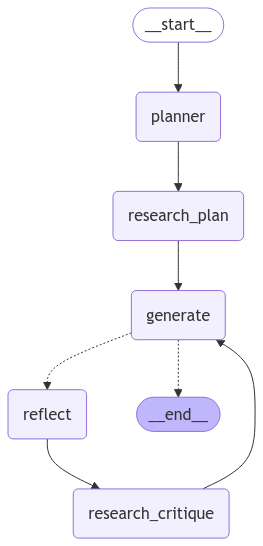

In [101]:
# from IPython.display import Image

# Image(graph.get_graph().draw_png())

from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [103]:
thread = {"configurable": {"thread_id": "2"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': '</think>\n\n**Essay Outline: The Difference Between LangChain and LangSmith**\n\n**I. Introduction**\n   - Brief introduction to the context of AI models in modern NLP.\n   - Mention the emergence of large language models (LLMs) like GPT-3, BERT, etc.\n   - Highlight the need for more efficient and effective methods for generating responses in real-time.\n\n**II. Overview of LangChain**\n   - Definition of LangChain: A framework designed to manage interactions with LLMs.\n   - Description of its architecture and purpose in managing context windows.\n   - Key components: Preprocessing, retrieval modules, and response generation.\n\n**III. Overview of LangSmith**\n   - Introduction to LangSmith as an alternative approach to LangChain.\n   - Description of its focus on optimizing the interaction process without relying on external storage.\n   - Explanation of how it operates within memory constraints.\n\n**IV. Key Differences Between LangChain and LangSmith**\n   - 

AttributeError: 'NoneType' object has no attribute 'queries'